In [32]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from scipy import stats

%matplotlib inline  

In [2]:
df = pd.read_csv('Consumo Gas Región Magallanes.csv', encoding='Windows-1252', delimiter=";")
df.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,Sábado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


In [3]:
df.index=pd.to_datetime(df.Año.astype(str)+df.Mes.astype(str)+df.Dia.astype(str), format="%Y%m%d")
df['Fecha']=  pd.to_datetime(df.Año.astype(str)+df.Mes.astype(str)+df.Dia.astype(str), format="%Y%m%d")
df['FinDeSemana'] = np.where(np.logical_or(df['DiaSemana'] == 'Sábado',df['DiaSemana'] == 'Domingo' ),1,0)
df.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado,Fecha,FinDeSemana
1995-10-20,716,20,10,1995,Viernes,0,1995-10-20,0
1995-10-21,605,21,10,1995,Sábado,1,1995-10-21,1
1995-10-22,555,22,10,1995,Domingo,1,1995-10-22,1
1995-10-23,680,23,10,1995,Lunes,0,1995-10-23,0
1995-10-24,713,24,10,1995,Martes,0,1995-10-24,0


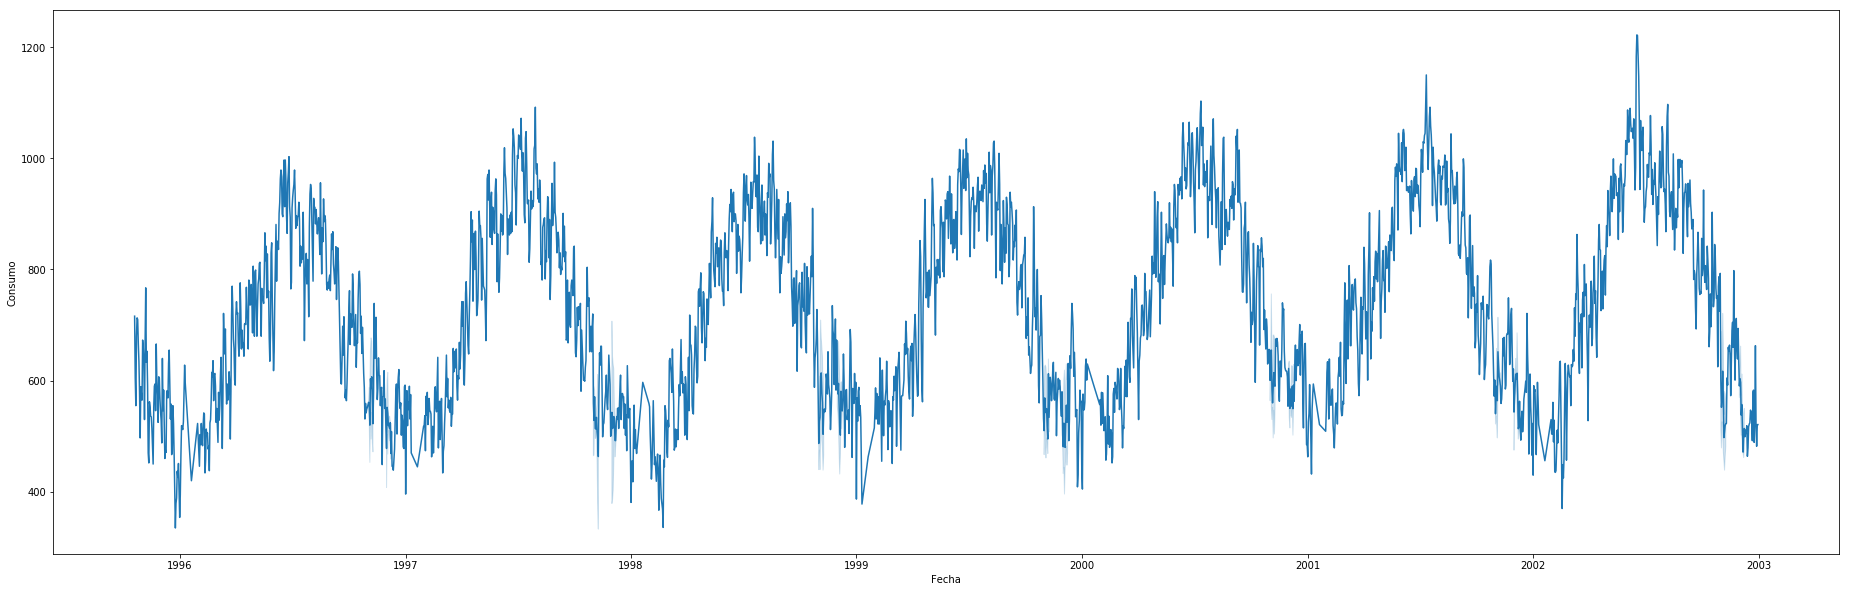

In [4]:
plt.subplots(figsize=(32, 10))
sns.lineplot(x='Fecha', y='Consumo', data=df)

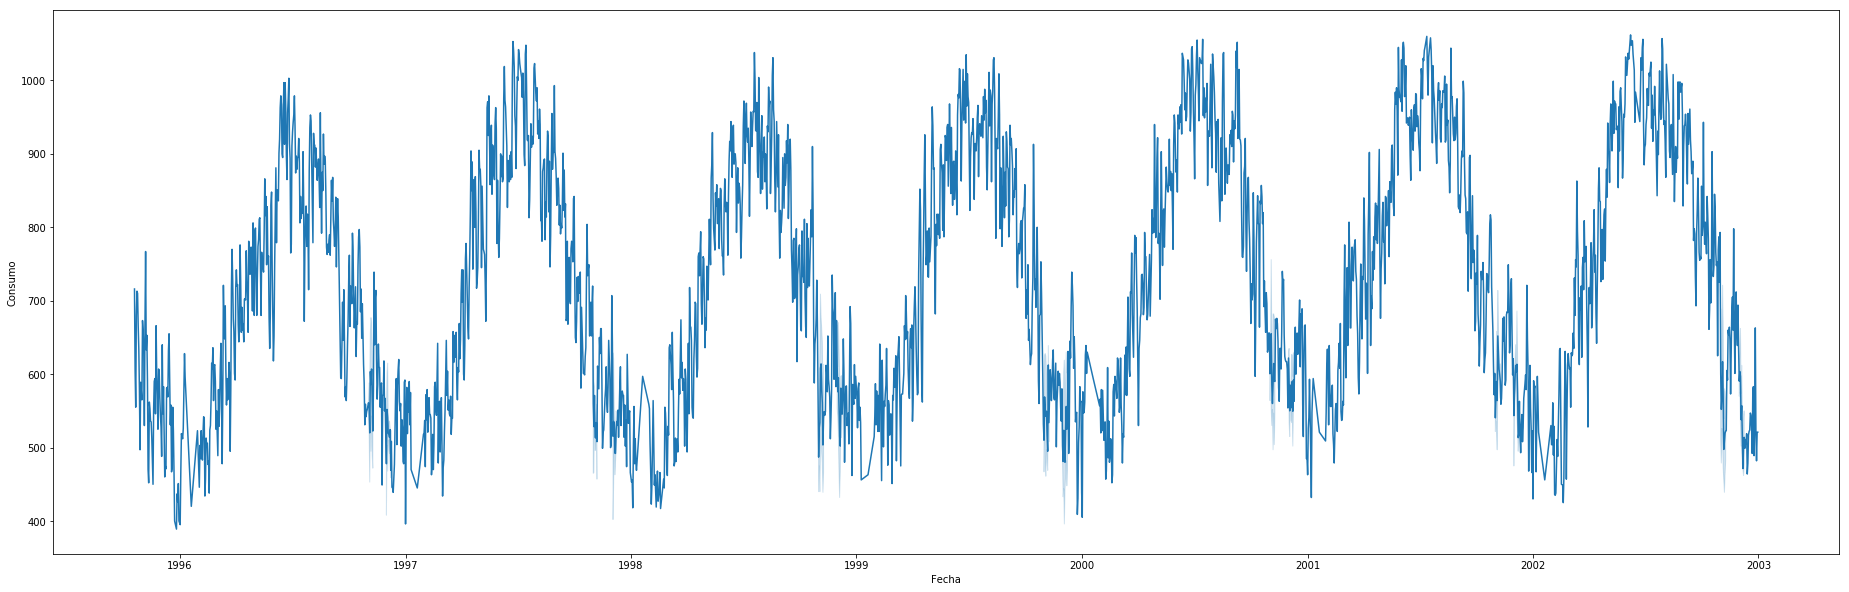

In [51]:


df_norm = df[np.abs(stats.zscore(a=df['Consumo']))<1.96]

plt.subplots(figsize=(32, 10))


sns.lineplot(x='Fecha', y='Consumo', data=df_norm)

In [33]:
plt.show()

In [52]:
prophtdf = df_norm.rename(columns={'Fecha': 'ds',
                        'Consumo': 'y'})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


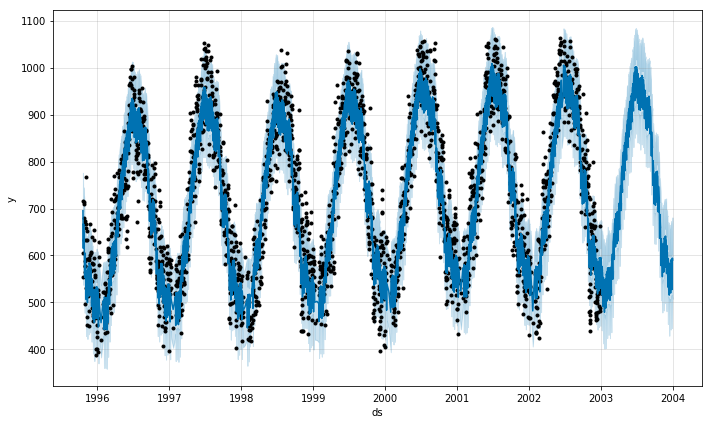

In [53]:
m = Prophet(seasonality_mode='additive')
m.fit(prophtdf)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)


fig1 = m.plot(forecast)

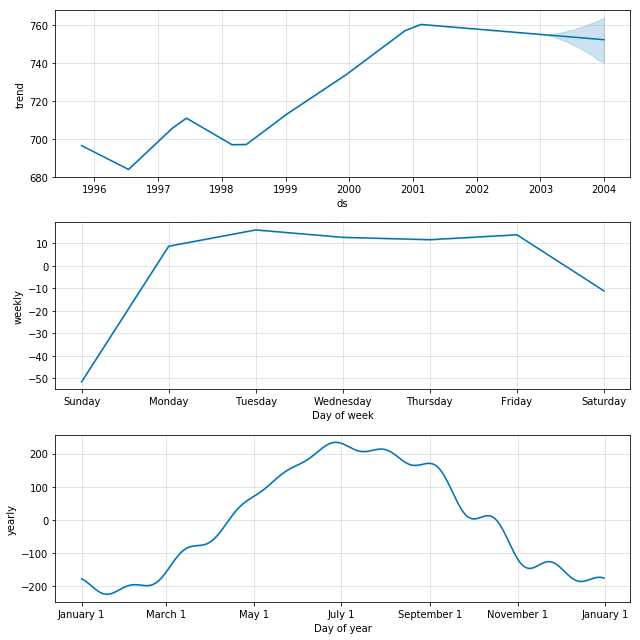

In [55]:
m.plot_components(forecast);


In [56]:
df_cv = cross_validation(m,  horizon = '365 days')

df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1999-01-01 00:00:00 and 2001-12-31 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,horizon,mse,rmse,mae,mape,coverage
2508,365 days,5769.551474,75.957564,60.906484,0.089636,0.70546


In [57]:
df_p['mse'].mean()

5769.551473938296

# Multiplicatio

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


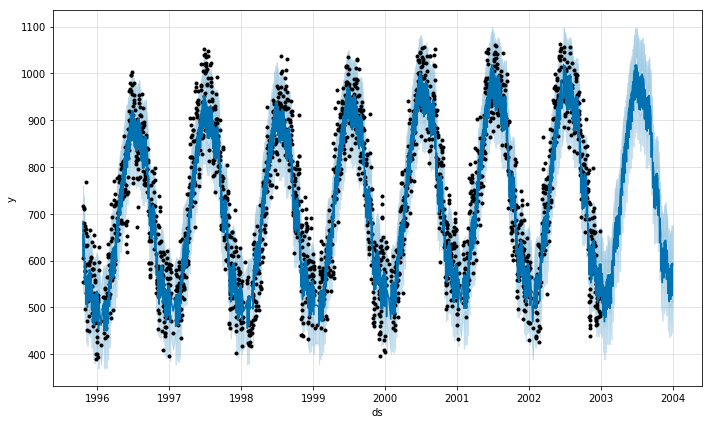

In [58]:
m_multiplicative = Prophet(seasonality_mode='multiplicative')
m_multiplicative.fit(prophtdf)
future_m = m_multiplicative.make_future_dataframe(periods=365)
forecast_m = m_multiplicative.predict(future_m)
fig = m_multiplicative.plot(forecast_m)

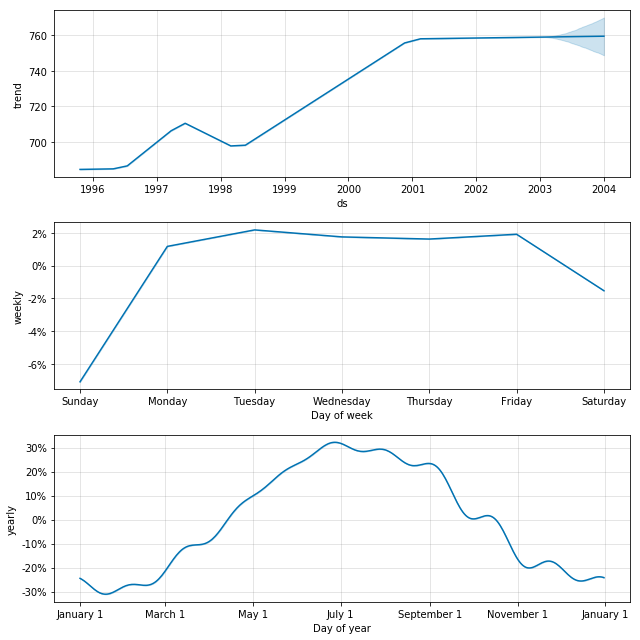

In [59]:
m_multiplicative.plot_components(forecast_m);



In [60]:
df_cv_m = cross_validation(m_multiplicative,  horizon = '365 days')

df_p_m = performance_metrics(df_cv_m, rolling_window=1)
df_p_m.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 1999-01-01 00:00:00 and 2001-12-31 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,horizon,mse,rmse,mae,mape,coverage
2508,365 days,5933.208952,77.027326,61.801204,0.089149,0.691511


In [29]:
df_p_m['mse'].mean()

6301.601561406605

# Holidays

In [75]:
df_norm[df_norm['Feriado']==1][['Feriado','Fecha']]

,Feriado,Fecha
1995-10-21,1,1995-10-21
1995-10-22,1,1995-10-22
1995-10-29,1,1995-10-29
1995-10-31,1,1995-10-31
1995-11-01,1,1995-11-01
1995-11-05,1,1995-11-05
1995-11-06,1,1995-11-06
1995-11-12,1,1995-11-12
1995-11-19,1,1995-11-19
1995-11-23,1,1995-11-23


In [68]:
df_norm

,Consumo,Dia,Mes,Año,DiaSemana,Feriado,Fecha,FinDeSemana
1995-10-20,716,20,10,1995,Viernes,0,1995-10-20,0
1995-10-21,605,21,10,1995,Sábado,1,1995-10-21,1
1995-10-22,555,22,10,1995,Domingo,1,1995-10-22,1
1995-10-23,680,23,10,1995,Lunes,0,1995-10-23,0
1995-10-24,713,24,10,1995,Martes,0,1995-10-24,0
1995-10-25,710,25,10,1995,Miércoles,0,1995-10-25,0
1995-10-26,666,26,10,1995,Jueves,0,1995-10-26,0
1995-10-27,634,27,10,1995,Viernes,0,1995-10-27,0
1995-10-28,578,28,10,1995,Sábado,0,1995-10-28,1
1995-10-29,497,29,10,1995,Domingo,1,1995-10-29,1


In [81]:
pd.read_excel('feriados2013.xlsx')['Fecha']

2013-01-01 00:00:00   2013-01-01
29/03/2013            2013-03-29
30/03/2013            2013-03-30
2013-01-05 00:00:00   2013-05-01
21/5/13               2013-05-21
29/6/13               2013-06-29
30/6/13               2013-06-30
16/7/13               2013-07-16
15/8/13               2013-08-15
18/9/13               2013-09-18
19/9/13               2013-09-19
20/9/13               2013-09-20
2013-12-10 00:00:00   2013-10-12
31/10/13              2013-10-31
2013-01-11 00:00:00   2013-11-01
17/11/13              2013-11-17
2013-08-12 00:00:00   2013-12-08
15/12/13              2013-12-15
25/12/13              2013-12-25
Name: Fecha, dtype: datetime64[ns]